# Text Classification Assignment

## Importing Module

In [1]:
import pandas as pd
# Read data into df
df = pd.read_csv("singapore_airlines_reviews.csv")   # singapore_airlines_reviews.csv
# Print head
df.head()

,published_date,published_platform,rating,type,text,title,helpful_votes
0,2024-03-12T14:41:14-04:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0
1,2024-03-11T19:39:13-04:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0
2,2024-03-11T12:20:23-04:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0
3,2024-03-11T07:12:27-04:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0
4,2024-03-10T05:34:18-04:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0


## Let’s Plot the Rating Field

<Axes: xlabel='rating'>

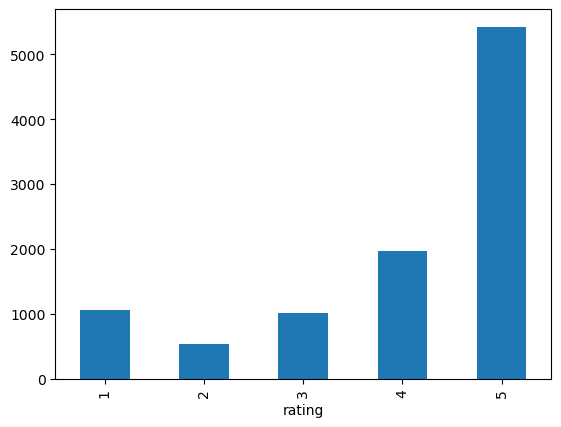

In [2]:
# Plotting the bar plot
df['rating'].value_counts().sort_index().plot(kind='bar')

## Let's Look at Published Platform

<Axes: xlabel='published_platform'>

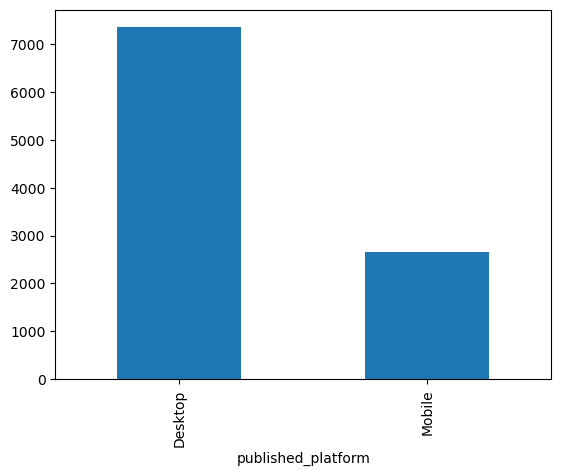

In [3]:
#Plotting the bar plot
df['published_platform'].value_counts().sort_index().plot(kind='bar')

## Function to Remove Any Odd Words

In [4]:
import html
import re
def clean(text):
    # convert html escapes like & to characters.
    text = html.unescape(text) 
    # tags like 
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches  but not #cool
    text = re.sub(r'(?:^|\s)[<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

## Data Cleaning

In [5]:
df = df[['title','text','rating']]
df = df.dropna()
df['Text'] = df['title'] + ' ' + df['text']
df = df.drop(columns=['title','text']) 
df['Text'] = df['Text'].apply(clean)
df = df[df['Text'].str.len() > 50]
df.sample(2)

,rating,Text
4335,3,"A long, noisy flight This flight between fligh..."
3435,4,Arrived early comfortable Early Friday morning...


## Train-Test Split

In [6]:
# Splitting the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df['Text'],
                                                    df['rating'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['rating'])
print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

Size of Training Data  7999
Size of Test Data  2000


## Converting X_train to Numbers

In [7]:
#Transforming the test data into TF-IDF features using the same vectorizer fitted on training data
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

## Building the Model

In [8]:
# Fitting the classifier to the training data
from sklearn.svm import LinearSVC

model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(random_state=0, tol=1e-05)

## Accuracy of the Model

In [9]:
from sklearn.metrics import accuracy_score
# Using the trained model to make predictions on the test data
Y_pred = model1.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))

Accuracy Score -  0.6665


## Run Dummy

In [10]:
# Calculating and printing the accuracy score
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy='most_frequent', random_state=42)
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

Accuracy Score -  0.5425


## Confusion Matrix

In [11]:
# Confusion Matrix Calculation
from sklearn.metrics import confusion_matrix
Y_pred = model1.predict(X_test_tf)
confusion_matrix(Y_test, Y_pred)

array([[141,  21,  29,   5,  15],
       [ 30,  17,  36,  12,  13],
       [ 26,  13,  72,  48,  43],
       [  8,   5,  27, 137, 217],
       [  9,   0,   9, 101, 966]], dtype=int64)

## Visualize Confusion Matrix

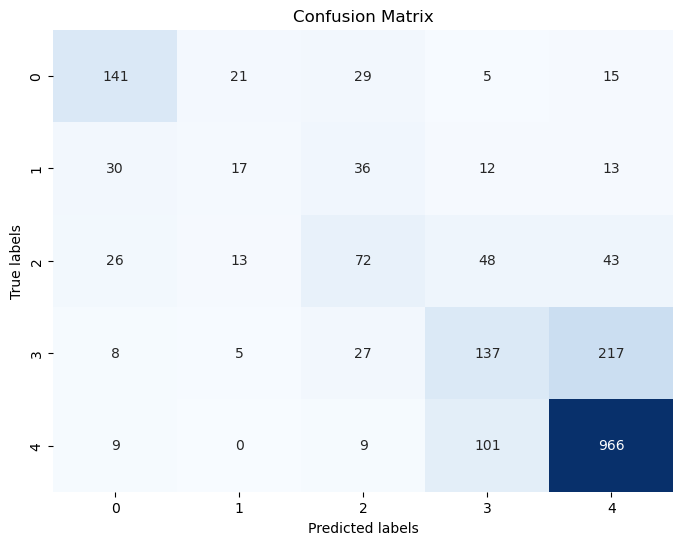

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(Y_test, model1.predict(X_test_tf))

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [13]:
# Generating and printing the classification report
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           1       0.66      0.67      0.66       211
           2       0.30      0.16      0.21       108
           3       0.42      0.36      0.38       202
           4       0.45      0.35      0.39       394
           5       0.77      0.89      0.83      1085

    accuracy                           0.67      2000
   macro avg       0.52      0.48      0.49      2000
weighted avg       0.63      0.67      0.65      2000



## Downsampling

In [14]:
# Filter bug reports with rating 4 and sample 4000 rows from it
df_sampleP3 = df[df['rating'] == 4].sample(n=4000, random_state=123, replace=True)

# Create a separate dataframe containing all other bug reports
df_sampleRest = df[df['rating'] != 4]

# Concatenate the two dataframes to create the new balanced bug reports dataset
df_balanced = pd.concat([df_sampleRest, df_sampleP3])

# Check the status of the class imbalance
df_balanced['rating'].value_counts()

rating
5    5424
4    4000
1    1057
3    1009
2     542
Name: count, dtype: int64

## Loading the Balanced Dataframe

In [15]:
df = df_balanced[['Text', 'rating']]
df = df.dropna()

# Step 1 - Data Preparation

df['Text'] = df['Text'].apply(clean)

# Step 2 - Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(df['Text'],
                                                    df['rating'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['rating'])
print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

# Step 3 - Training the Machine Learning model

tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)

model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

# Step 4 - Model Evaluation

X_test_tf = tfidf.transform(X_test)
Y_pred = model1.predict(X_test_tf)
print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Size of Training Data  9625
Size of Test Data  2407


C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy Score -  0.7424179476526797
              precision    recall  f1-score   support

           1       0.67      0.65      0.66       212
           2       0.27      0.15      0.19       108
           3       0.41      0.28      0.33       202
           4       0.72      0.84      0.78       800
           5       0.84      0.84      0.84      1085

    accuracy                           0.74      2407
   macro avg       0.58      0.55      0.56      2407
weighted avg       0.72      0.74      0.73      2407



In [16]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
# Flag that determines the choice of SVC (True) and LinearSVC (False)
runSVC = True
# Loading the dataframe
df = pd.read_csv('singapore_airlines_reviews.csv')
df = df[['title', 'text', 'published_platform']]
df = df.dropna()
df['Text'] = df['title'] + df['text']
df = df.drop(columns=['title', 'text'])
# Step 1 - Data Preparation
df['Text'] = df['Text'].apply(clean)
df = df[df['Text'].str.len() > 50]
if (runSVC):
    # Sample the data when running SVC to ensure reasonable run-times
    df = df.groupby('published_platform', as_index=False).apply(pd.DataFrame.sample,
                                                       random_state=42,
                                                       frac=.2)
# Step 2 - Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(df['Text'],
                                                    df['published_platform'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['published_platform'])
print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])
# Step 3 - Training the Machine Learning model
tfidf = TfidfVectorizer(stop_words="english")
if (runSVC):
    model = SVC(random_state=42, probability=True)
    grid_param = [{
        'tfidf__min_df': [5, 10],
        'tfidf__ngram_range': [(1, 3), (1, 6)],
        'model__C': [1, 100],
        'model__kernel': ['linear']
    }]
else:
    model = LinearSVC(random_state=42, tol=1e-5)
    grid_param = {
        'tfidf__min_df': [5, 10],
        'tfidf__ngram_range': [(1, 3), (1, 6)],
        'model__C': [1, 100],
        'model__loss': ['hinge']
    }
training_pipeline = Pipeline(
    steps=[('tfidf', TfidfVectorizer(stop_words="english")), ('model', model)])
gridSearchProcessor = GridSearchCV(estimator=training_pipeline,
                                   param_grid=grid_param,
                                   cv=5)
gridSearchProcessor.fit(X_train, Y_train)
best_params = gridSearchProcessor.best_params_
print("Best alpha parameter identified by grid search ", best_params)

best_result = gridSearchProcessor.best_score_
print("Best result identified by grid search ", best_result)

best_model = gridSearchProcessor.best_estimator_

# Step 4 - Model Evaluation

Y_pred = best_model.predict(X_test)
print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Size of Training Data  1600
Size of Test Data  400
Best alpha parameter identified by grid search  {'model__C': 1, 'model__kernel': 'linear', 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 6)}
Best result identified by grid search  0.728125
Accuracy Score -  0.7175
              precision    recall  f1-score   support

     Desktop       0.74      0.96      0.83       294
      Mobile       0.27      0.04      0.07       106

    accuracy                           0.72       400
   macro avg       0.50      0.50      0.45       400
weighted avg       0.61      0.72      0.63       400

